# MOWNIT -  Computional Methods AGH UST 2024
## Laboratory 4, Task 3

### Finding Hard Sudoku's Solution by Simulated Annealing (SA)

Simulated Annealing can be used in various different situations. This is the example of situation where it is not likely to use SA due to the fact, that it does not work as efficient as other approaches.

#### Algorithm Overview:

1. **Initial Solution**: Randomly fill the gaps in the given sudoku grid, ensuring that each 3x3 square contains no repeating numbers.
  
2. **Cost Evaluation**: Evaluate the cost of the current solution. The cost of a solution is the sum of costs for every row and column. The cost of a single row or column is incremented for every repeated number within that row or column. The goal is to minimize the cost of the solution. The sudoku is considered solved when its cost equals 0.
  
3. **Cell Swapping**: Cells can only be swapped if they are within the same small 3x3 square. This ensures that repetitions only occur in rows and columns. Swap can not include cells that were given at start.
  
4. **Iteration**: In each iteration, randomly swap two cells. If the new solution has a lower cost, it is always accepted. If the new solution has a higher cost, it is accepted with a probability based on the current temperature.
  
5. **Avoiding Local Minimums**:
   - The probability of accepting a worse solution increases with the number of iterations since the last improvement.
   - After a certain number of iterations (approximately 80,000), restart the entire simulation. This involves resetting the temperature and randomly filling the sudoku grid with numbers once again.
  
6. **Termination**: The simulation can be terminated after a given number of iterations or run indefinitely until a solution is found.


## Results 

Remember, that results may differ depending on pure luck. From what i have tested, the algorithm is able to solve all 50 sudokus in relatively quick time (on my computer circa 15 minut). The quickest solutions are less than a second and the slowest are usually around 1-2 minutes. 

Source of `sudoku.txt` file: `https://github.com/dimitri/sudoku/blob/master/sudoku.txt` 

Imports:

In [204]:
import numpy as np
import random
import math
from copy import deepcopy 
import matplotlib.pyplot as plt
import time

Functions related to reading `sudoku.txt` file.

In [216]:
def read_sudoku(i):
    sudoku = np.zeros((9, 9), dtype=int)    
    with open('sudoku.txt', 'r') as file:
            lines = file.readlines()
            start_idx = 10*i-9
            end_idx = start_idx+9 
            for row_idx, line in enumerate(lines[start_idx:end_idx]):  
                line = line.strip()  
                
                for col_idx, char in enumerate(line):
                        sudoku[row_idx, col_idx] = int(char)
        
    return sudoku
  
def fill_sudoku(sudoku):
    original = set()
    def fill_one_square(square_no):
        nonlocal sudoku
        nonlocal original
        USED =set()
        start_row = 3* (square_no//3)
        start_col = 3* (square_no%3)
        ROWS = [start_row, start_row+1, start_row+2]
        COLS = [start_col,start_col+1,start_col+2]
        for row in  ROWS:
            for col in COLS:
                if sudoku[row,col] !=0:
                    original.add((row,col))
                    USED.add(sudoku[row,col])
        ALL = {1,2,3,4,5,6,7,8,9}
        UNUSED = list(ALL.difference(USED)) 
        for row in ROWS:
            for col in COLS:
                if sudoku[row,col] !=0:
                    continue
                elem = random.choice(UNUSED)
                UNUSED.remove(elem)
                sudoku[row,col] = elem 
    for square_no in range(9):
          fill_one_square(square_no) 
    return sudoku,original

Code related to calculations of cost function

In [203]:
def calculate_row_cost(sudoku,row):
    counter = [0]*9 
    cost = 0
    for col in range(9):
        counter[sudoku[row,col]-1] +=1; 
    for count in counter:
        if count >1:
            cost+=(count-1)
    return cost 

def calculate_col_cost(sudoku,col):
    counter = [0]*9 
    cost = 0
    for row in range(9):
        counter[sudoku[row,col]-1] +=1; 
    for count in counter:
        if count >1:
            cost+=(count-1)
    return cost 

def calculate_cost(sudoku):
    cost = 0 
    for num in range(9):
        cost+= calculate_row_cost(sudoku,num) 
        cost+= calculate_col_cost(sudoku,num)

    return cost 

def change_of_cost(old_sdk,new_sdk,cost,x1,y1,x2,y2):
    
    cost-=calculate_row_cost(old_sdk,x1)
    cost+=calculate_row_cost(new_sdk,x1)

    cost-=calculate_row_cost(old_sdk,x2)
    cost+=calculate_row_cost(new_sdk,x2) 

    cost-=calculate_col_cost(old_sdk,y1)
    cost+=calculate_col_cost(new_sdk,y1)

    cost-=calculate_col_cost(old_sdk,y2)
    cost+=calculate_col_cost(new_sdk,y2) 
     
    return cost 



Implemented Algorithm:

In [217]:
class sudoku_solver:
        def __init__(self,i,T,alpha,RESET_ITER=80_000):
                self.sudoku_number = i
                self.original_sudoku = read_sudoku(i)
                self.sudoku,self.original = fill_sudoku(self.original_sudoku)
                self.cost = calculate_cost(self.sudoku)
                self.T = T 
                self.T_original = T
                self.alpha = alpha 
                self.last_update = 0 
                self.RESET_ITER = RESET_ITER
                self.ratio = []
                self.solution_iter = 0
                self.solve_sudoku()

        def p_accept(self,nghb_cost):
                return math.exp(-abs(nghb_cost - self.cost) / ( self.T )) +  math.pow(self.last_update,2)/math.pow(10,7) 

        def swap(self,sdk,a,b):
                x1 = a[0]
                x2 = b[0]
                y1 = a[1]
                y2 = b[1]
                sdk[x1,y1],sdk[x2,y2] = sdk[x2,y2],sdk[x1,y1]
                return sdk, change_of_cost(self.sudoku,sdk,self.cost,x1,y1,x2,y2)

        def random_swap(self):
                neighbour = deepcopy(self.sudoku)  
                while True:
                        square_no = random.randint(0,8)
                        a,b,c,d = np.random.choice(3, size=4)
                        x1 = 3 * (square_no // 3)  + a
                        x2 = 3 * (square_no // 3) + b 
                        y1 = 3 * (square_no % 3 )  + c
                        y2 = 3 * (square_no % 3 ) + d 
                        if not (x1 ==x2 and y1==y2) and not (x1,y1) in self.original and not (x2,y2) in self.original:
                                break
                return self.swap(neighbour,(x1,y1),(x2,y2)) 

        def solve_sudoku(self):
                for iter in range(1,2_000_000):

                        if iter%self.RESET_ITER==0:
                                self.sudoku = fill_sudoku(self.original_sudoku)[0]
                                self.cost = calculate_cost(self.sudoku)
                                self.T = self.T_original
                                self.last_update = 0 

                        if self.cost==0:
                                print("wow! succes on sudoku ",self.sudoku_number, ". Number of iterations: ", iter)
                                self.solution_iter = iter
                                return 0
                        
                        neighbour, new_cost = self.random_swap() 
                        if new_cost < self.cost:
                                self.last_update = 0 
                                self.cost = new_cost 
                                self.sudoku = neighbour 
                        elif random.random() < self.p_accept(new_cost):                                
                                self.cost = new_cost 
                                self.sudoku = neighbour

                        self.last_update+=1
                        self.T*=self.alpha
                        self.ratio.append((iter,self.cost))
                print("more than 2 000 000 iterations needed for sudoku ", self.sudoku_number, "....")
                return -1         

Plot drawing functions:

In [220]:
def plot_iter(coordinates):
    x_coords, y_coords = zip(*coordinates)
    
    plt.plot(x_coords, y_coords)

    plt.title('numbers of iterations needed for solution: ')
    plt.xlabel('sudoku number')
    plt.ylabel('iterations')

    plt.show()

def plot_annealing(coordinates, sudoku_number):
    x_coords, y_coords = zip(*coordinates)
    
    plt.plot(x_coords, y_coords)

    plt.title('Annealing process of sudoku  ' + str(sudoku_number))
    plt.xlabel('Current cost')
    plt.ylabel('iterations')

    plt.show()


Tests:

wow! succes on sudoku  1 . Number of iterations:  2430
wow! succes on sudoku  2 . Number of iterations:  5706


wow! succes on sudoku  3 . Number of iterations:  178725
wow! succes on sudoku  4 . Number of iterations:  14427
wow! succes on sudoku  5 . Number of iterations:  5604
wow! succes on sudoku  6 . Number of iterations:  243887
wow! succes on sudoku  7 . Number of iterations:  33534
wow! succes on sudoku  8 . Number of iterations:  2088
wow! succes on sudoku  9 . Number of iterations:  331046
wow! succes on sudoku  10 . Number of iterations:  133804
wow! succes on sudoku  11 . Number of iterations:  7495
wow! succes on sudoku  12 . Number of iterations:  7020
wow! succes on sudoku  13 . Number of iterations:  374646
wow! succes on sudoku  14 . Number of iterations:  13980
wow! succes on sudoku  15 . Number of iterations:  177963
wow! succes on sudoku  16 . Number of iterations:  1628
wow! succes on sudoku  17 . Number of iterations:  1764
wow! succes on sudoku  18 . Number of iterations:  7033
wow! succes on sudoku  19 . Number of iterations:  2499
wow! succes on sudoku  20 . Number of it

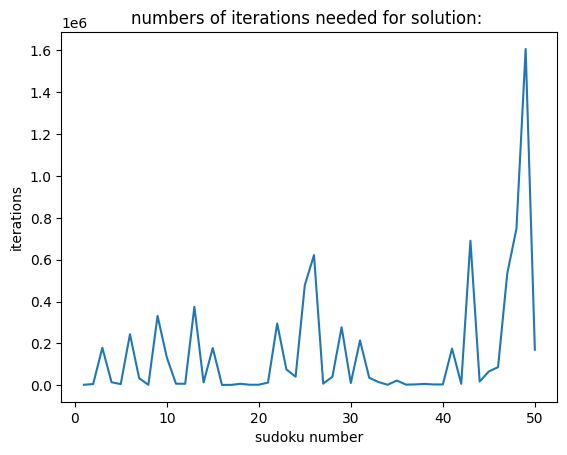

In [215]:
T = 1 
alpha = 0.9995

coordinates= []
for i in range(1,51):
    s = sudoku_solver(i,T,alpha)
    coordinates.append((i,s.solution_iter))
plot_iter(coordinates)

Examples of  how Annealing process plot usually look:


wow! succes on sudoku  1 . Number of iterations:  8500


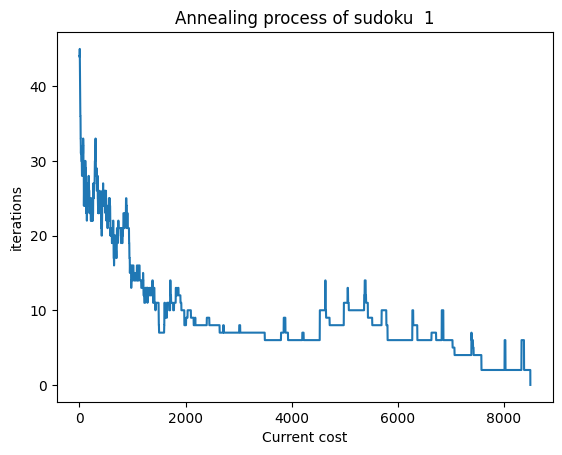

wow! succes on sudoku  5 . Number of iterations:  3020


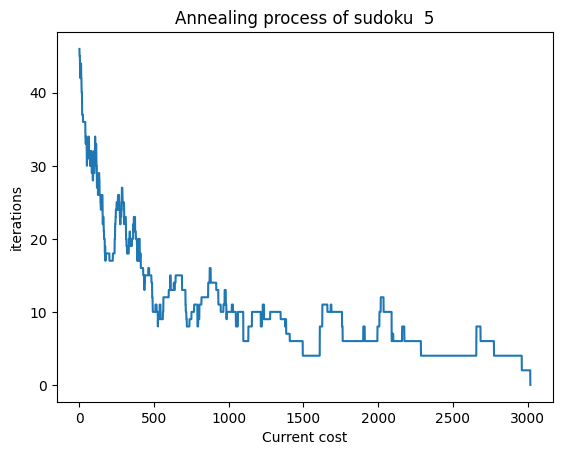

wow! succes on sudoku  10 . Number of iterations:  242123


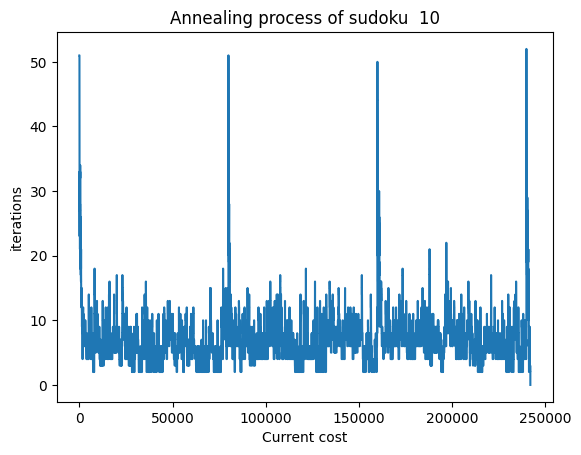

wow! succes on sudoku  20 . Number of iterations:  25344


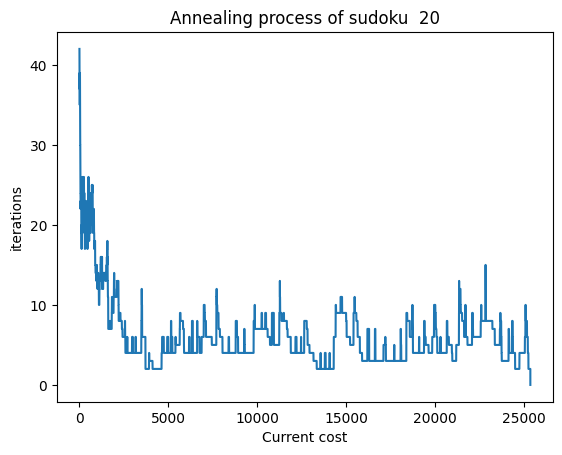

In [221]:
T = 1 
alpha = 0.9995

for sudoku_number in [1,5,10,20]:
    s = sudoku_solver(sudoku_number,T,alpha)
    plot_annealing(s.ratio, sudoku_number)